In [46]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras import layers, Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization, GlobalMaxPooling2D
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adamax
from sklearn.metrics import confusion_matrix, classification_report
import itertools

import matplotlib.pyplot as plt
import shutil

In [13]:
# Define the image size, batch size, and dataset path
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
DATASET_PATH = '/content/drive/My Drive/Plant Disease'  # Update to the actual dataset path
NUM_CLASSES = 5  # Assuming 4 classes of diseases, including healthy leaves

In [14]:
# Initialize lists for storing file paths and corresponding labels
filepaths = []
labels = []

# Print the folder names to debug
print(f"Folders found in dataset: {os.listdir(DATASET_PATH)}")

# Iterate over each folder in the dataset directory
folds = os.listdir(DATASET_PATH)
for fold in folds:
    foldpath = os.path.join(DATASET_PATH, fold)

    # Ensure the current fold is a directory
    if os.path.isdir(foldpath):
        print(f"Processing folder: {fold}")  # Debugging output to check folder names

        filelist = os.listdir(foldpath)

        # Iterate over each file in the current fold
        for file in filelist:
            fpath = os.path.join(foldpath, file)

            # Optionally, filter out non-image files (e.g., by extension)
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.tiff', '.bmp', '.gif')):
                filepaths.append(fpath)
                labels.append(fold)  # The folder name is used as the label
            else:
                print(f"Skipped file (not an image): {file}")  # Debugging output for skipped files

# Create a DataFrame with file paths and labels
Fseries = pd.Series(filepaths, name='filepaths')
Lseries = pd.Series(labels, name='labels')
data = pd.concat([Fseries, Lseries], axis=1)

# Optionally, display the first few rows of the DataFrame to verify
print(data.head())

# Also display the count of files per label
print(data['labels'].value_counts())


Folders found in dataset: ['Mango Scab', 'Mango scale', 'Healthy', 'Mango Anthracnose', 'Bacterial Canker']
Processing folder: Mango Scab
Processing folder: Mango scale
Processing folder: Healthy
Processing folder: Mango Anthracnose
Processing folder: Bacterial Canker
                                           filepaths      labels
0  /content/drive/My Drive/Plant Disease/Mango Sc...  Mango Scab
1  /content/drive/My Drive/Plant Disease/Mango Sc...  Mango Scab
2  /content/drive/My Drive/Plant Disease/Mango Sc...  Mango Scab
3  /content/drive/My Drive/Plant Disease/Mango Sc...  Mango Scab
4  /content/drive/My Drive/Plant Disease/Mango Sc...  Mango Scab
labels
Mango Scab           500
Healthy              500
Mango Anthracnose    500
Bacterial Canker     500
Mango scale          498
Name: count, dtype: int64


In [15]:
train_data, dummy_data = train_test_split(data,  test_size= 0.2, shuffle= True, random_state= 123)

valid_data, test_data = train_test_split(dummy_data,  test_size= 0.4, shuffle= True, random_state= 123)

In [36]:
# #image generator

# batch_size = 16
# img_size = (224, 224)
# channels = 3
# img_shape = (img_size[0], img_size[1], channels)

# ts_length = len(test_data)
# test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
# test_steps = ts_length // test_batch_size

# def scalar(img):
#     return img

# tr_gen = ImageDataGenerator(preprocessing_function= scalar)
# ts_gen = ImageDataGenerator(preprocessing_function= scalar)

# train_gen = tr_gen.flow_from_dataframe( train_data, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
#                                     color_mode= 'rgb', shuffle= True, batch_size= batch_size)

# valid_gen = ts_gen.flow_from_dataframe( valid_data, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
#                                     color_mode= 'rgb', shuffle= True, batch_size= batch_size)

# test_gen = ts_gen.flow_from_dataframe( test_data, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
#                                     color_mode= 'rgb', shuffle= False, batch_size= test_batch_size)
# Parameters
batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

# Adjust test batch size and steps calculation
ts_length = len(test_data)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length % n == 0 and ts_length // n <= 80]))
test_steps = ts_length // test_batch_size

# Preprocessing function (rescale images to [0, 1] range)
def scalar(img):
    return img / 255.0  # Normalize image pixels to [0,1] range

# Train, validation, and test generators
tr_gen = ImageDataGenerator(preprocessing_function=scalar)
ts_gen = ImageDataGenerator(preprocessing_function=scalar)

# Training data generator
train_gen = tr_gen.flow_from_dataframe(
    train_data,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,  # Shuffle during training
    batch_size=batch_size
)

# Validation data generator (no shuffling)
valid_gen = ts_gen.flow_from_dataframe(
    valid_data,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False,  # No shuffling during validation
    batch_size=batch_size
)

# Test data generator (no shuffling)
test_gen = ts_gen.flow_from_dataframe(
    test_data,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False,  # No shuffling during testing
    batch_size=test_batch_size
)

Found 1998 validated image filenames belonging to 5 classes.
Found 300 validated image filenames belonging to 5 classes.
Found 200 validated image filenames belonging to 5 classes.


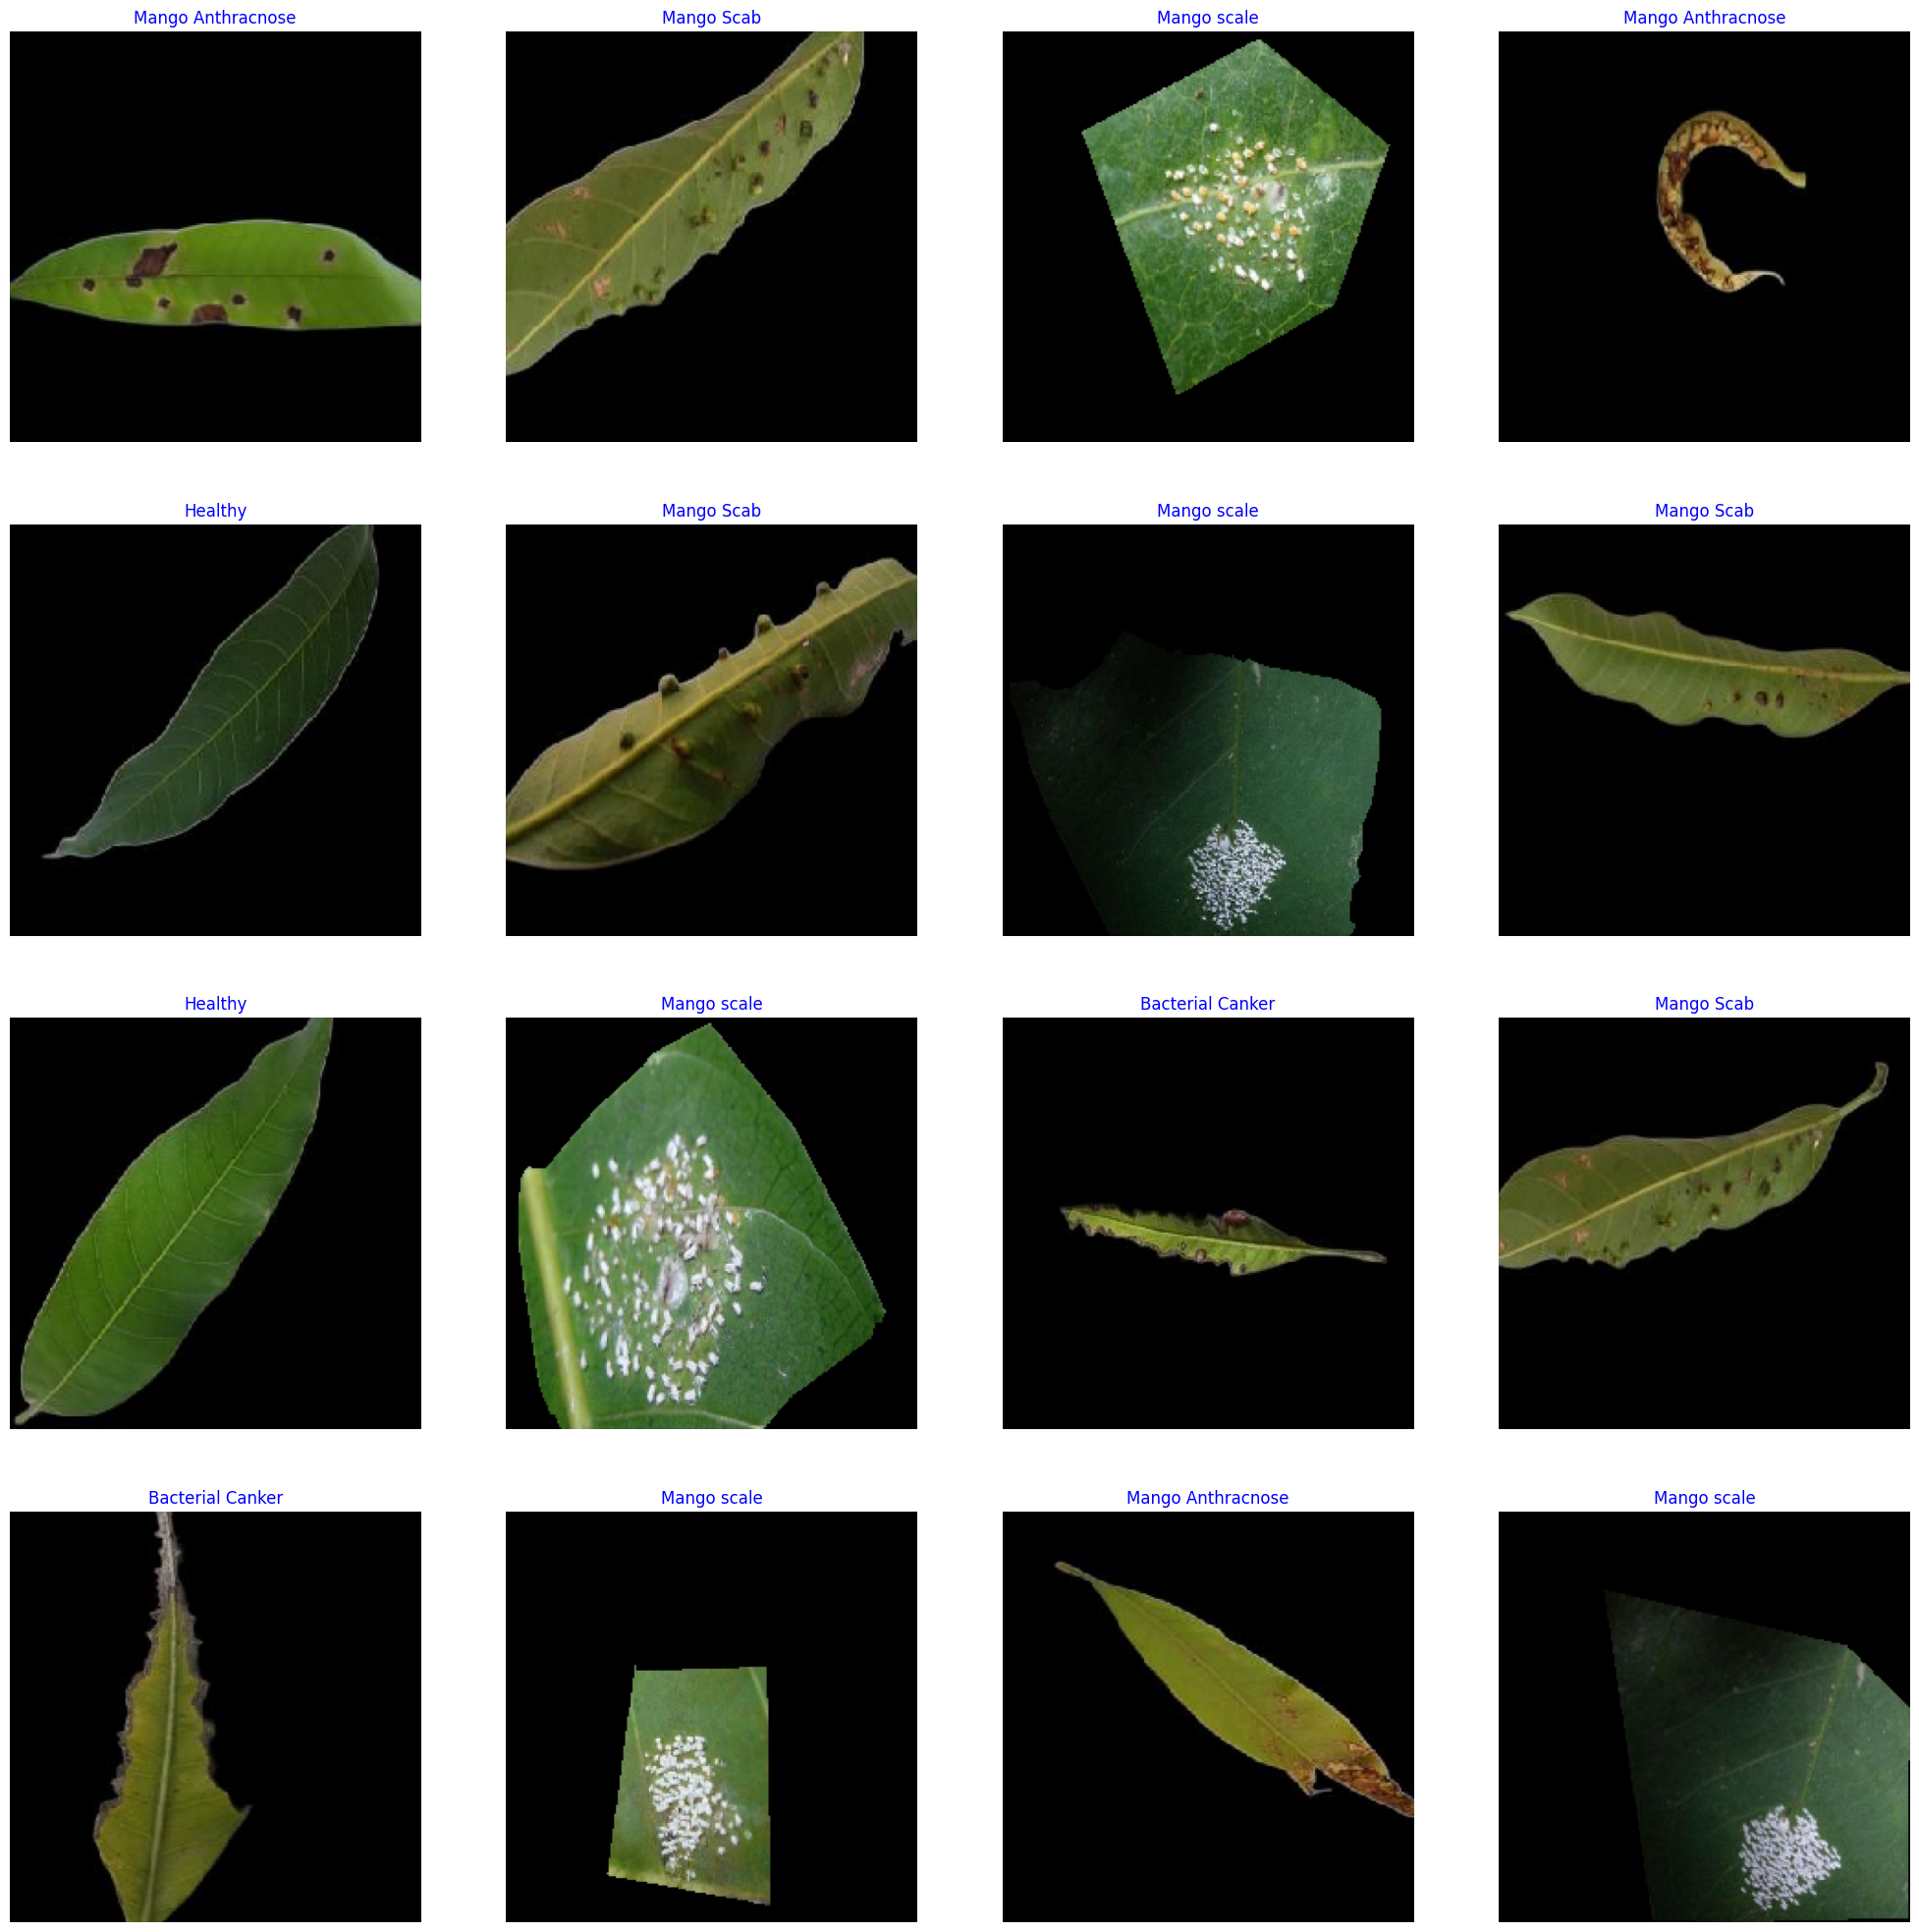

In [38]:
# g_dict = train_gen.class_indices
# classes = list(g_dict.keys())
# images, labels = next(train_gen)

# plt.figure(figsize= (25, 25))

# for i in range(16):
#     plt.subplot(4, 4, i + 1)
#     image = images[i] / 255
#     plt.imshow(image)
#     index = np.argmax(labels[i])
#     class_name = classes[index]
#     plt.title(class_name, color= 'blue', fontsize= 12)
#     plt.axis('off')
# plt.show()
# Get class indices from the generator
g_dict = train_gen.class_indices
classes = list(g_dict.keys())

# Fetch a batch of images and labels
images, labels = next(train_gen)

# Set up the plot
plt.figure(figsize=(25, 25))

# Loop through the first 16 images
for i in range(16):
    plt.subplot(4, 4, i + 1)

    # No need to divide by 255 again, images are already normalized
    image = images[i]

    # Plot the image
    plt.imshow(image)

    # Get the index of the class with the highest probability
    index = np.argmax(labels[i])

    # Map the index to the class name
    class_name = classes[index]

    # Set the title
    plt.title(class_name, color='blue', fontsize=12)

    # Turn off axis for each subplot
    plt.axis('off')

# Show the plot
plt.show()

In [39]:
import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GlobalMaxPooling2D
from tensorflow.keras.optimizers import Adamax

# Modelling
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

# Assuming 'train_gen' is your training generator with class labels
class_count = len(list(train_gen.class_indices.keys()))  # to define number of classes in the dense layer

# Base EfficientNetB0 model
base_model = tf.keras.applications.EfficientNetB0(include_top=False, weights="imagenet", input_shape=img_shape)

# Add pooling to flatten the output
x = base_model.output
x = GlobalMaxPooling2D()(x)

# Unfreeze the last few layers of EfficientNetB0
for layer in base_model.layers[-30:]:
    layer.trainable = True

# Additional layers
x = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(x)
# x = Dense(256, kernel_regularizer=regularizers.l2(l2=0.016),  # Corrected: Use l2 instead of l
#           activity_regularizer=regularizers.l1(0.006),
#           bias_regularizer=regularizers.l1(0.006), activation='relu')(x)
# Reduce or remove regularizers
x = Dense(256, activation='relu')(x)
x = Dropout(rate=0.45, seed=123)(x)

# Output layer for classification
output = Dense(class_count, activation='softmax')(x)

# Final model
model = Model(inputs=base_model.input, outputs=output)

model.compile(Adamax(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


# Display the model summary
model.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_14            │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_28 (Rescaling)  │ (None, 224, 224, 3)    │              0 │ input_layer_14[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization_14          │ (None, 224, 224, 3)    │              7 │ rescaling_28[0][0]     │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_29 (Rescaling)  │ (None, 224, 224, 3)    │              0 │ normalization_14[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ rescaling_29[0][0]     │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 32)   │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 32)   │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 32)   │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 32)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 4,383,912 (16.72 MB)

 Trainable params: 4,339,329 (16.55 MB)

 Non-trainable params: 44,583 (174.16 KB)

In [40]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Parameters
batch_size = 16
epochs = 10

# Calculate the number of validation steps (if needed)
validation_steps = len(valid_gen) // batch_size

# Add ModelCheckpoint to save the best model during training
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, mode='min')

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Training the model
history = model.fit(
    x=train_gen,
    epochs=epochs,
    verbose=1,
    validation_data=valid_gen,
    validation_steps=validation_steps,
    shuffle=True,  # Set shuffle to True to shuffle data between epochs
    callbacks=[checkpoint, early_stopping]  # Adding the callbacks
)


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


125/125 ━━━━━━━━━━━━━━━━━━━━ 587s 4s/step - accuracy: 0.4142 - loss: 1.6530 - val_accuracy: 0.1250 - val_loss: 2.1248
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 560s 4s/step - accuracy: 0.7609 - loss: 0.6596 - val_accuracy: 0.2500 - val_loss: 2.4212
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 531s 4s/step - accuracy: 0.8630 - loss: 0.3971 - val_accuracy: 0.1875 - val_loss: 2.7238
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 558s 4s/step - accuracy: 0.8977 - loss: 0.2725 - val_accuracy: 0.7500 - val_loss: 0.8864
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 535s 4s/step - accuracy: 0.9327 - loss: 0.1986 - val_accuracy: 0.8125 - val_loss: 0.4599
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 556s 4s/step - accuracy: 0.9433 - loss: 0.1683 - val_accuracy: 1.0000 - val_loss: 0.0634
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 560s 4s/step - accuracy: 0.9574 - loss: 0.1185 - val_accuracy: 0.9375 - val_loss: 0.1574
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 530s 4s/step - accuracy: 0.9655 - loss: 0.1092 - val_accuracy: 1.000

In [41]:
# Define test batch size and steps for evaluation
ts_length = len(test_data)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length % n == 0 and ts_length / n <= 80]))

# Calculate steps for train, validation, and test data
train_steps = len(train_gen)
valid_steps = len(valid_gen)
test_steps = len(test_gen)

# Evaluate the model on training data
train_score = model.evaluate(train_gen, steps=train_steps, verbose=1)

# Evaluate the model on validation data
valid_score = model.evaluate(valid_gen, steps=valid_steps, verbose=1)

# Evaluate the model on test data
test_score = model.evaluate(test_gen, steps=test_steps, verbose=1)

# Print out the evaluation results
print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])


125/125 ━━━━━━━━━━━━━━━━━━━━ 145s 1s/step - accuracy: 0.9922 - loss: 0.0282
19/19 ━━━━━━━━━━━━━━━━━━━━ 18s 952ms/step - accuracy: 0.9815 - loss: 0.0615
4/4 ━━━━━━━━━━━━━━━━━━━━ 26s 7s/step - accuracy: 0.9453 - loss: 0.1147
Train Loss:  0.03092808835208416
Train Accuracy:  0.9904904961585999
--------------------
Validation Loss:  0.05528496578335762
Validation Accuracy:  0.9800000190734863
--------------------
Test Loss:  0.12364372611045837
Test Accuracy:  0.9599999785423279


5/5 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


5/5 ━━━━━━━━━━━━━━━━━━━━ 14s 3s/step


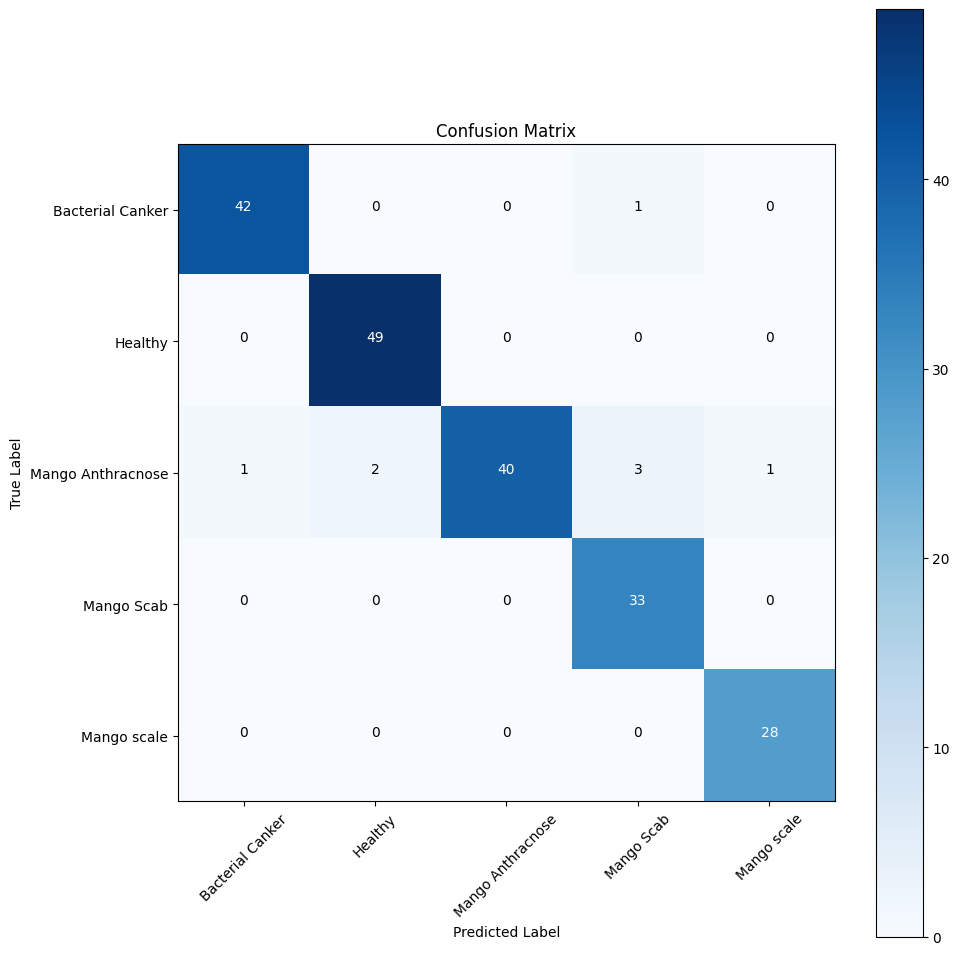

In [47]:

#Prediction#
# Make predictions using the model
preds = model.predict(test_gen, steps=test_gen.samples // test_gen.batch_size + 1, verbose=1)

# Convert predicted probabilities to class indices
y_pred = np.argmax(preds, axis=1)

#Confusion Matrix#
# Get the class indices and classes from the test generator
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Generate predictions for the test set
y_pred_probs = model.predict(test_gen, steps=test_gen.samples // test_gen.batch_size + 1, verbose=1)

# Convert predictions from probabilities to predicted class indices
y_pred = np.argmax(y_pred_probs, axis=1)

# Get true labels from the test generator
y_true = test_gen.classes

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

# Set tick marks for classes
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

# Annotate the confusion matrix
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()


In [48]:
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

                   precision    recall  f1-score   support

 Bacterial Canker       0.98      0.98      0.98        43
          Healthy       0.96      1.00      0.98        49
Mango Anthracnose       1.00      0.85      0.92        47
       Mango Scab       0.89      1.00      0.94        33
      Mango scale       0.97      1.00      0.98        28

         accuracy                           0.96       200
        macro avg       0.96      0.97      0.96       200
     weighted avg       0.96      0.96      0.96       200

